# COBYLA optimization with mutable spline points

In [45]:
import sys, os
import numpy as np
import matplotlib as mpl
import scipy as sc
from scipy import interpolate

from motors.simulation import *
from motors.plot import prepare_plot
prepare_plot()
from motors.aesthetics import setup_plot


%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)
cmap = sns.color_palette("Paired", 10)

## First, reproduce the previous results...

In [6]:
def objective(spline_points):
    x_points = [0, 10, 20, 30, 40, 50, 59]

    xnew = np.arange(60)
    energy = interpolate.spline(x_points, spline_points, xnew=xnew)
    energies.append(energy)
    
    this = Simulation(data_source = 'manual')
    this.unbound = energy
    this.bound = interpolate.spline(x_points, [3, 4, 5, 0, 1, 2, 3], xnew=xnew)

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3  # molar

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

In [28]:
def plot_results(energies, fluxes, method, iterations):
    fig, ax = setup_plot('Apo energy surface (kcal mol$^{-1}$)', 'Bin')
    c = sns.color_palette("Blues", n_colors=len(energies))
    for index, energy in enumerate(energies):
        ax.plot(range(60), energy, color=c[index])
    for spline_point in [0, 10, 20, 30, 40, 50, 59]:
        ax.scatter(spline_point, energy[spline_point],  color='r', edgecolor='k', lw=1, s=120, zorder=10)
    paper_plot(fig)

    fig, ax = setup_plot('Flux (cycle s$^{-1}$)', 'Bin')
    for index, flux in enumerate(fluxes):
        ax.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    paper_plot(fig)

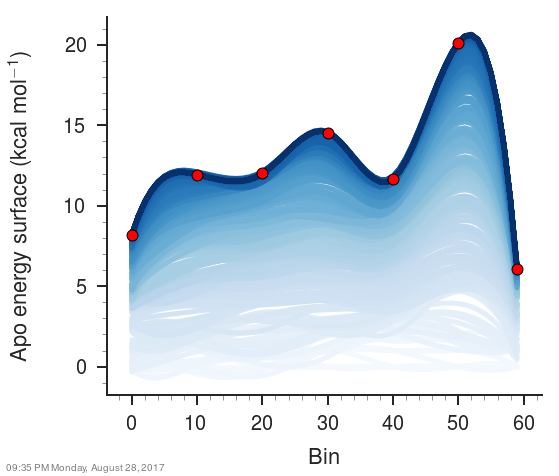

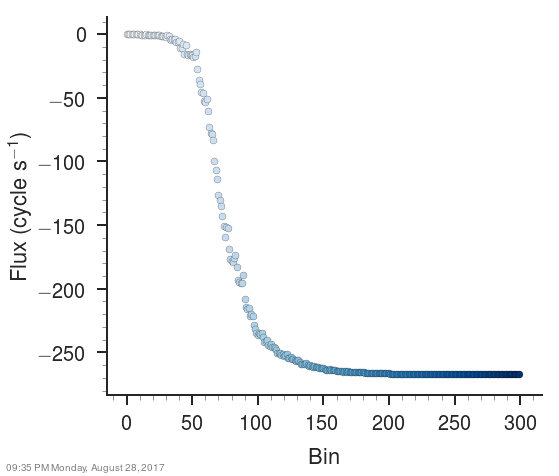

In [29]:
guess = [0, 0, 0, 0, 0, 0, 0]
energies = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective, guess, method='COBYLA')
plot_results(energies, fluxes, 'COBYLA', results['nfev'])

## Let's allow the spline points to be picked randomly

In [7]:
def objective(spline_y, spline_x):
    
    full_range = np.arange(60)
    
    energy = interpolate.spline(spline_x, spline_y, xnew=full_range)
    energies.append(energy)
    
    this = Simulation(data_source = 'manual')
    this.unbound = energy
    this.bound = interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=full_range)

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3  # molar

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

In [50]:
def plot_results(energies, fluxes, method, iterations, spline_x):
    
    fig, ax = setup_plot('Bound energy surface (kcal mol$^{-1}$)', 'Bin')
    bound = interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=range(60))
    ax.plot(range(60), bound, color='k')
    for spline_point in spline_x:
        ax.scatter(spline_point, bound[spline_point],  color='r', edgecolor='k', lw=1, s=120, zorder=10)
    paper_plot(fig)
    
    fig, ax = setup_plot('Apo energy surface (kcal mol$^{-1}$)', 'Bin')
    c = sns.color_palette("Blues", n_colors=len(energies))
    for index, energy in enumerate(energies):
        ax.plot(range(60), energy, color=c[index])
    for spline_point in spline_x:
        ax.scatter(spline_point, energy[spline_point],  color='r', edgecolor='k', lw=1, s=120, zorder=10)
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax.add_artist(at)
    paper_plot(fig)

    fig, ax = setup_plot('Flux (cycle s$^{-1}$)', 'Bin')
    for index, flux in enumerate(fluxes):
        ax.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    paper_plot(fig)

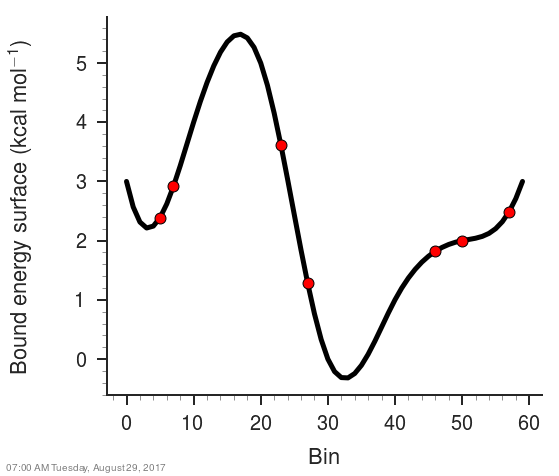

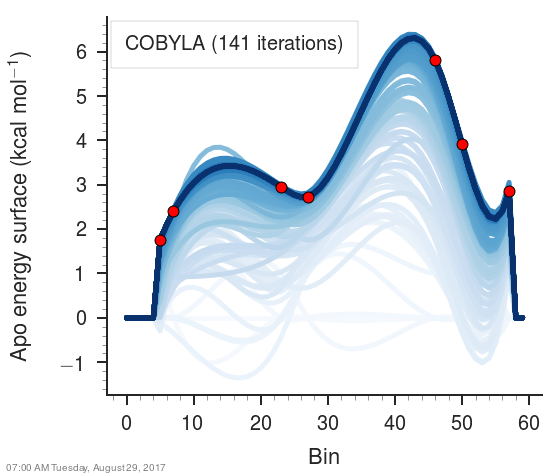

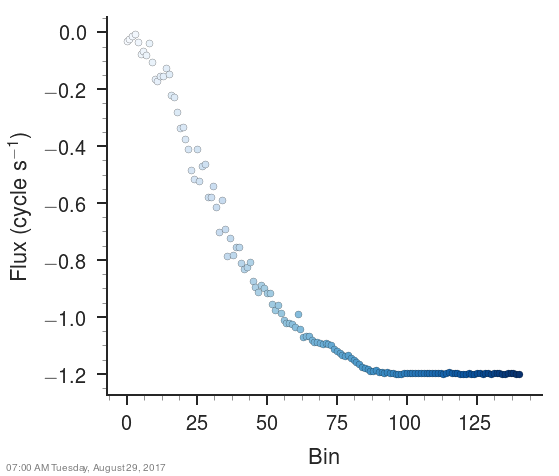

In [54]:
spline_x = np.sort(np.random.randint(low=0, high=59, size=7))
guess = [0, 0, 0, 0, 0, 0, 0]
energies = []
fluxes = []
np.random.seed(None)
results = sc.optimize.minimize(objective, guess, method='COBYLA', args=(spline_x))
plot_results(energies, fluxes, 'COBYLA', results['nfev'], spline_x)

In [55]:
results

     fun: -1.2004338420836271
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 141
  status: 1
 success: True
       x: array([ 1.76548861,  2.40147542,  2.95365457,  2.73385473,  5.80131402,
        3.91058599,  2.85910577])

In [62]:
for seed in range(50):
    spline_x = np.sort(np.random.randint(low=0, high=59, size=7))
    guess = [0, 0, 0, 0, 0, 0, 0]
    energies = []
    fluxes = []
    np.random.seed(seed)
    try:
        results = sc.optimize.minimize(objective, guess, method='COBYLA', args=(spline_x))
        print('Seed\t{}\tEvaluations\t{}\tFlux\t{}'.format(seed, results['nfev'], results['fun']))
    except:
        continue

Seed	0	Evaluations	75	Flux	-0.09176445854241043


/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:140: RuntimeWarning: overflow encountered in exp
  np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:142: RuntimeWarning: overflow encountered in exp
  np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:199: RuntimeWarning: overflow encountered in exp
  np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:245: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Seed	2	Evaluations	65	Flux	-2573345568.907473
Seed	3	Evaluations	152	Flux	-0.40087982293855856
Seed	4	Evaluations	169	Flux	-4.620788567650304
Seed	5	Evaluations	165	Flux	-4.76103480311823
Seed	6	Evaluations	147	Flux	-0.5170107575146972
Seed	7	Evaluations	127	Flux	-0.39408096078056093
Seed	8	Evaluations	357	Flux	-1.1622858333558725
Seed	9	Evaluations	138	Flux	-0.6962059122271322
Seed	11	Evaluations	177	Flux	-0.9112351131798808
Seed	12	Evaluations	83	Flux	-744153324065.5991
Seed	14	Evaluations	219	Flux	-0.5447302605606031
Seed	15	Evaluations	150	Flux	-1.0403080939985103
Seed	16	Evaluations	147	Flux	-2.331853089107367
Seed	17	Evaluations	513	Flux	-2.959185269352944
Seed	18	Evaluations	84	Flux	-1328637052243880.5
Seed	19	Evaluations	76	Flux	-528252.2970524029
Seed	20	Evaluations	112	Flux	-0.29516168301147444


/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2628: RuntimeWarning: divide by zero encountered in true_divide
  tmp = dot(tmp,np.diag(1.0/s))
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:232: RuntimeWarning: invalid value encountered in greater
  if np.any(row_sums > 1):


Seed	23	Evaluations	250	Flux	-1.6723796851942703
Seed	26	Evaluations	205	Flux	-0.9584759846611405
Seed	27	Evaluations	132	Flux	-1.3259522198521532
Seed	29	Evaluations	150	Flux	-3.1009856422257447
Seed	30	Evaluations	76	Flux	-0.1635764632341661
Seed	33	Evaluations	80	Flux	-7474719503912.871


/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:199: RuntimeWarning: overflow encountered in double_scalars
  np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +


Seed	35	Evaluations	78	Flux	-1373124418.4791825
Seed	37	Evaluations	88	Flux	-1.6871874452929196e+19
Seed	38	Evaluations	116	Flux	-0.7289581545834949
Seed	42	Evaluations	121	Flux	-0.24400188635767298
Seed	43	Evaluations	133	Flux	-0.6258032575736242
Seed	44	Evaluations	249	Flux	-8.53332061883272
Seed	46	Evaluations	87	Flux	-6326755.209833445
Seed	47	Evaluations	879	Flux	-1.4102783184346284


In [34]:
def plot_summary(energies, fluxes, method, iterations, spline_x):
    
    fig = plt.figure(figsize=(6 * 1.2 * 2, 6))
    gs = GridSpec(1, 2, wspace=0.4, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    c = sns.color_palette("Blues", n_colors=len(energies))

    for index, energy in enumerate(energies):
        ax1.plot(range(60), energy, color=c[index])
    for spline_point in spline_x:
        ax1.scatter(spline_point, energy[spline_point],  color='r', edgecolor='k', lw=1, s=120, zorder=10)
    
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2)
    at.patch.set(boxstyle='square', alpha=0.5)
    ax1.add_artist(at)
    ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
    ax1.set_xlabel('Bin')
    
    for index, flux in enumerate(fluxes):
        ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    ax2.set_ylabel('Flux (cycle s$^{-1}$)')
    ax2.set_xlabel('Optimization iteration')
    paper_plot(fig)
    plt.show()

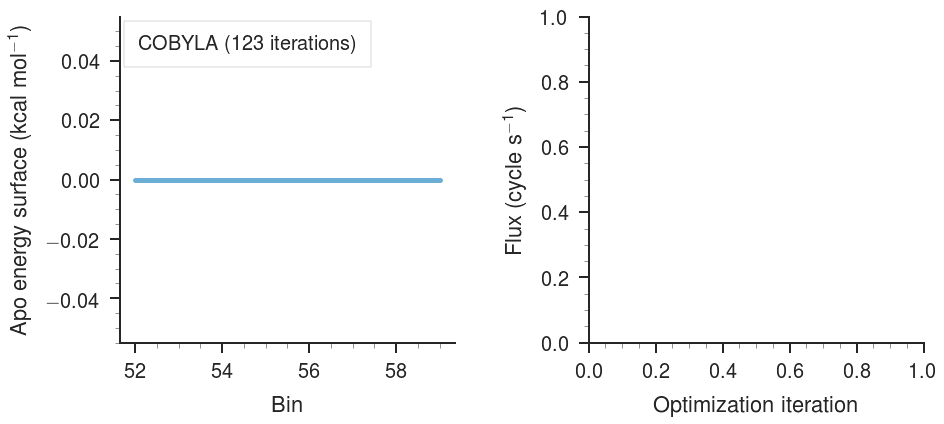

In [50]:
plot_summary(energies, fluxes, 'COBYLA', 123, spline_x)

In [51]:
def objective_pinned(spline_y, spline_x):
    
    for index, point in enumerate(spline_y):
        if point >= 10:
            spline_y[index] = 10
        if point <= 0:
            spline_y[index] = 0
    
    full_range = np.arange(60)
    energy = interpolate.spline(spline_x, spline_y, xnew=full_range)
    energies.append(energy)
    
    this = Simulation(data_source = 'manual')
    this.unbound = energy
    this.bound = interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=full_range)

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3  # molar

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)

Seed	0	Evaluations	74	Flux	-0.09136112784872238


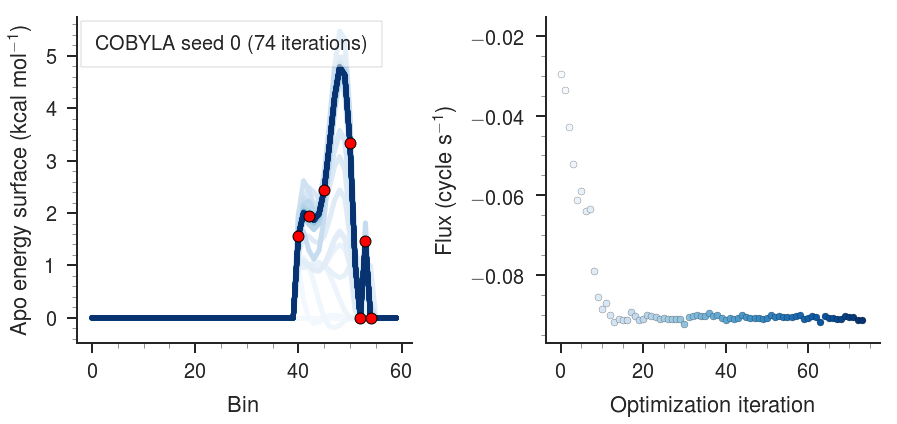

/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:140: RuntimeWarning: overflow encountered in exp
  np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:142: RuntimeWarning: overflow encountered in exp
  np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:199: RuntimeWarning: overflow encountered in exp
  np.exp(-1 * (unbound_surface[i] - bound_surface[i]) / float(self.kT)) +
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:245: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


Seed	2	Evaluations	75	Flux	21258779770.39488


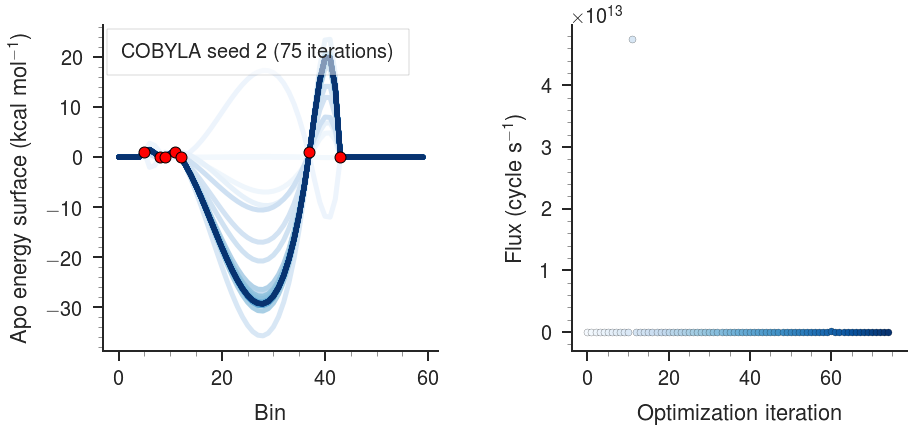

Seed	3	Evaluations	99	Flux	-0.17697753572985403


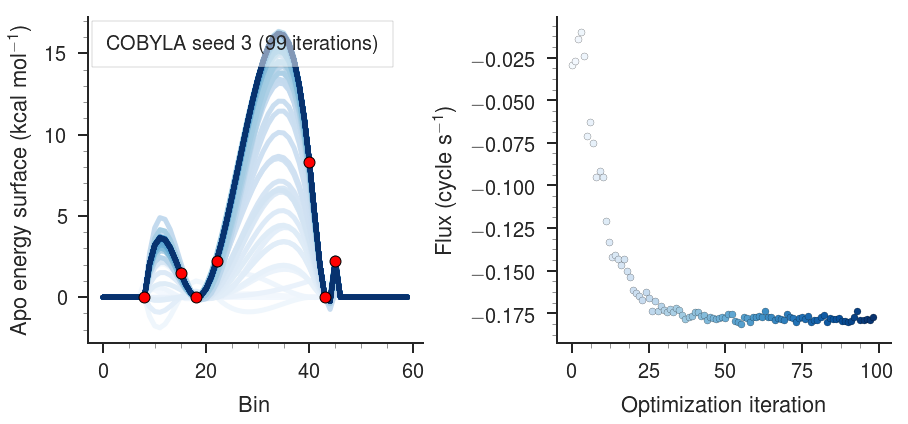

Seed	4	Evaluations	143	Flux	-3.155804998220406


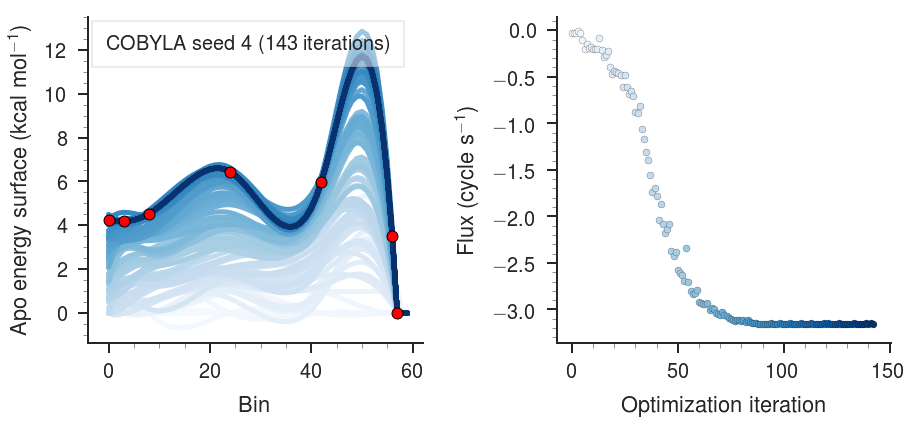

Seed	5	Evaluations	131	Flux	-3.1685761567856767


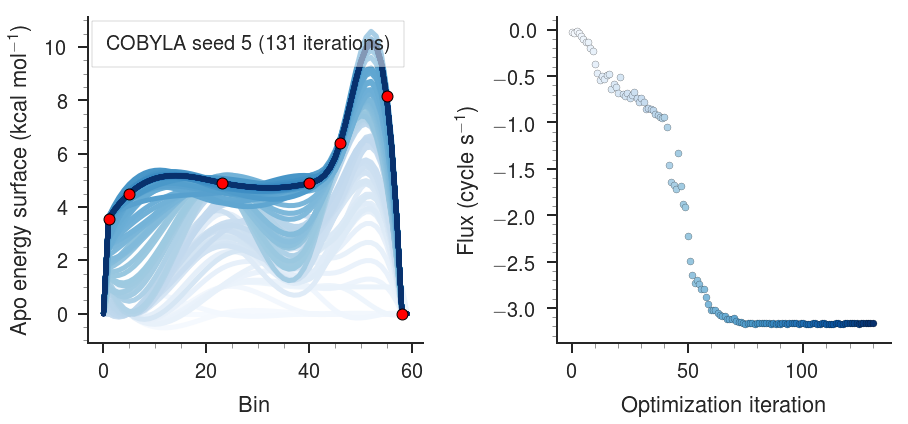

Seed	6	Evaluations	88	Flux	-0.27246433743303744


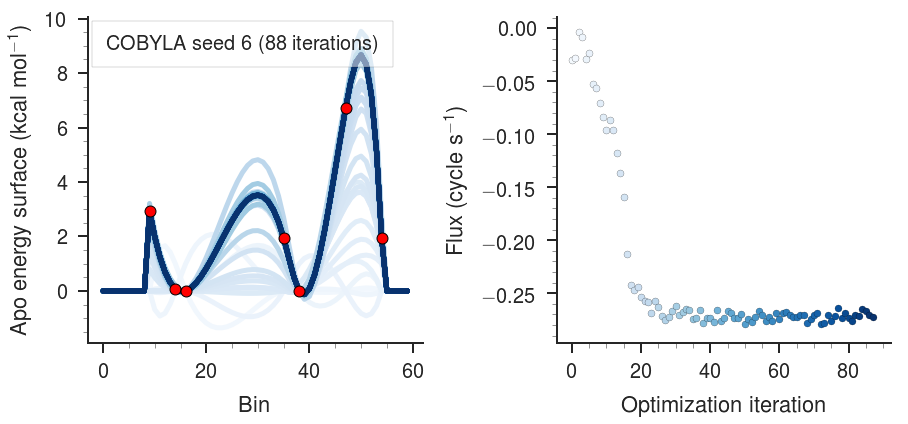

Seed	7	Evaluations	99	Flux	-0.3247995832960347


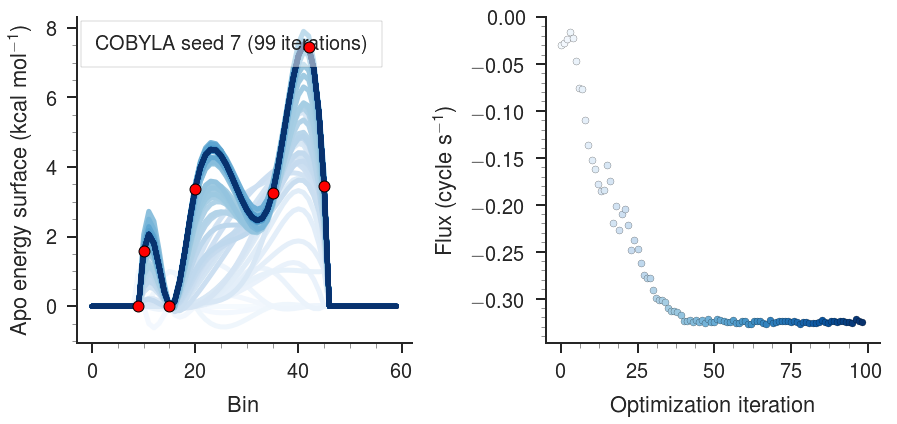

Seed	8	Evaluations	153	Flux	-0.5617236485309112


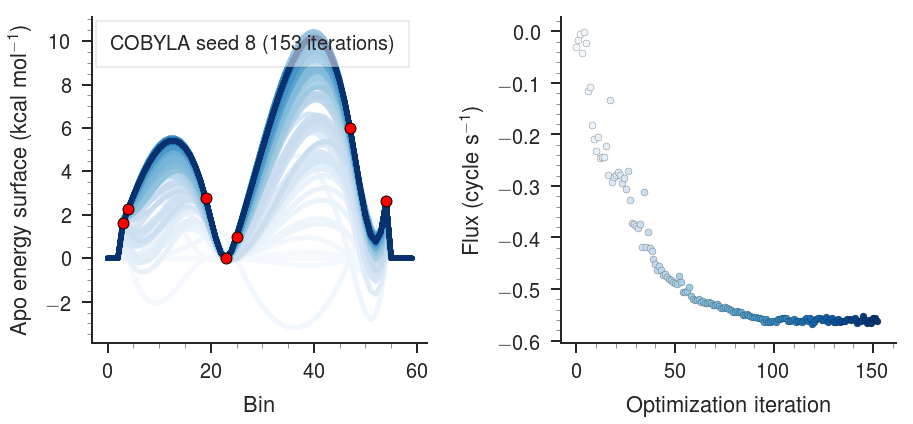

Seed	9	Evaluations	117	Flux	-0.6310386289679741


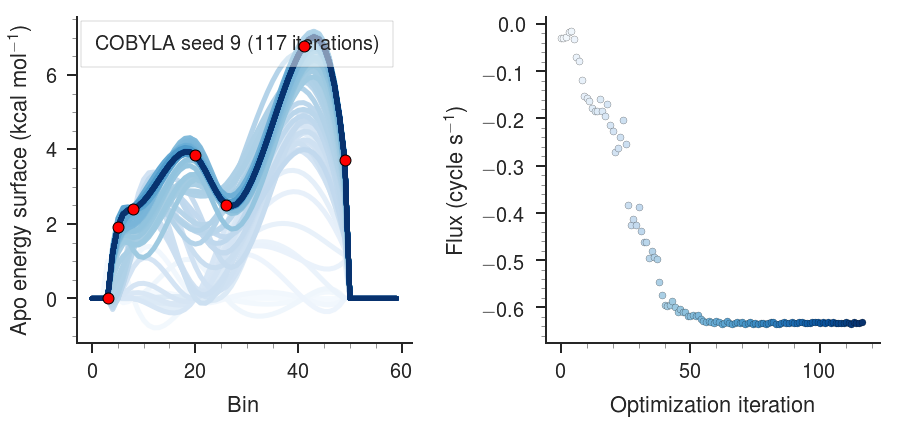

Seed	11	Evaluations	92	Flux	-0.5272744948394821


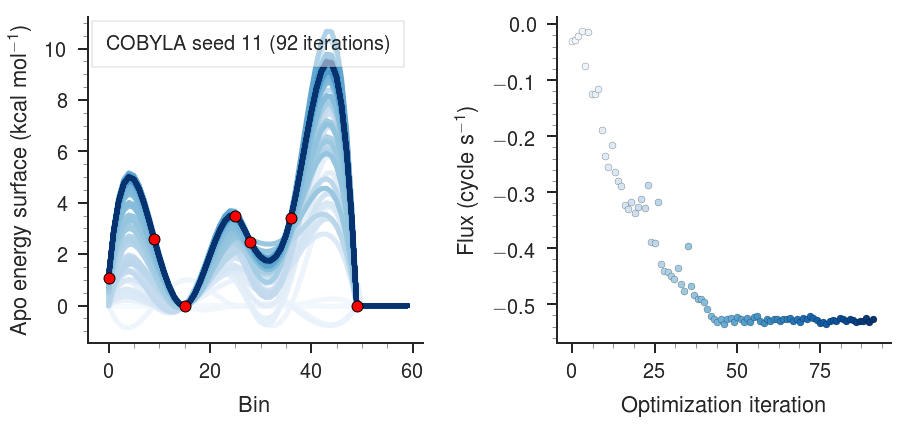

Seed	12	Evaluations	64	Flux	3730498892.8970065


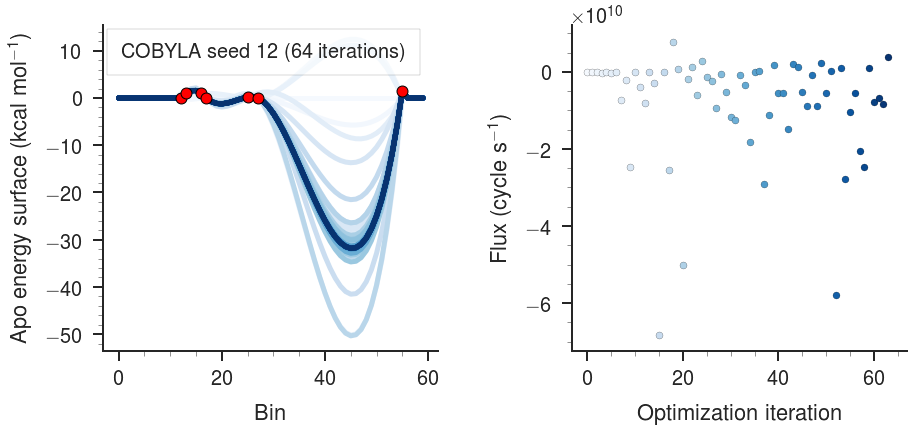

Seed	14	Evaluations	206	Flux	-0.3380390978555037


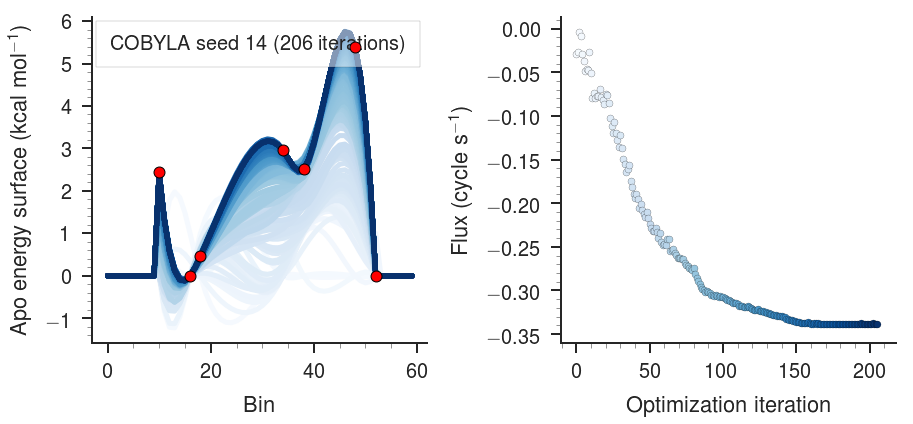

Seed	15	Evaluations	121	Flux	-0.4366649516481876


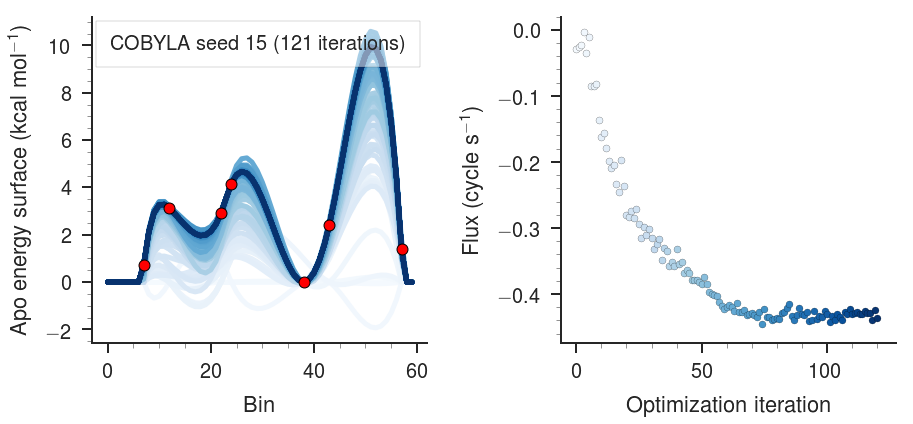

Seed	16	Evaluations	119	Flux	-1.868284019267016


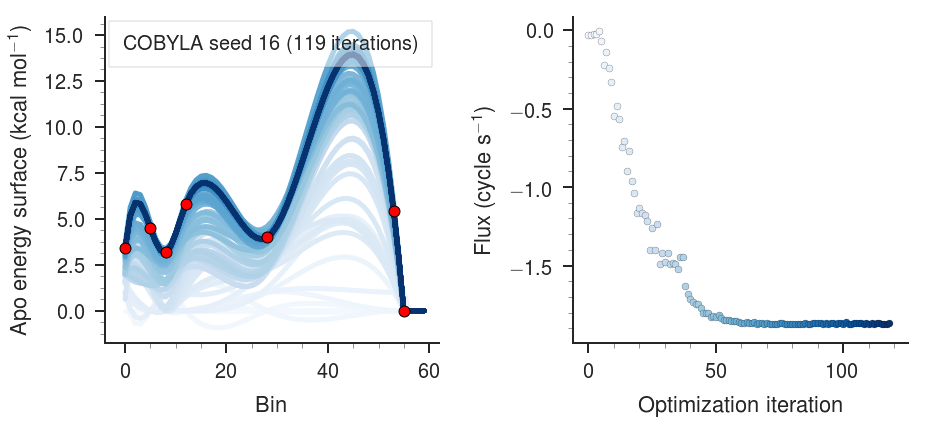

Seed	17	Evaluations	154	Flux	-1.2740769179130504


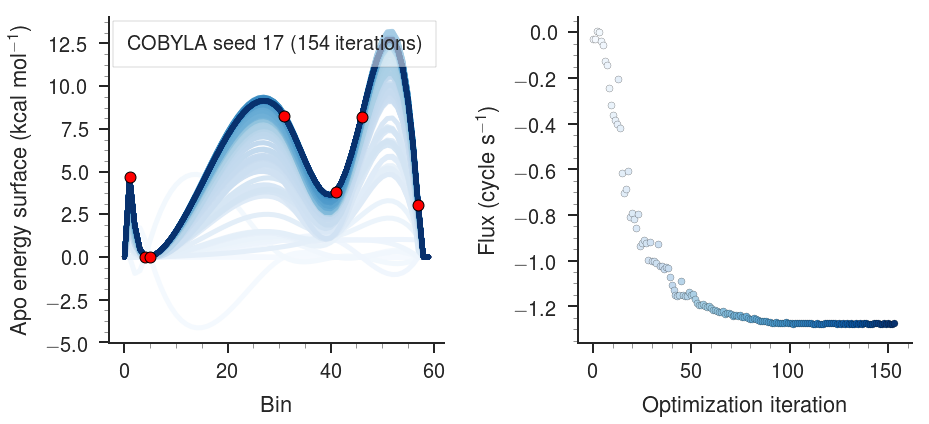

Seed	18	Evaluations	80	Flux	-0.31328115525714867


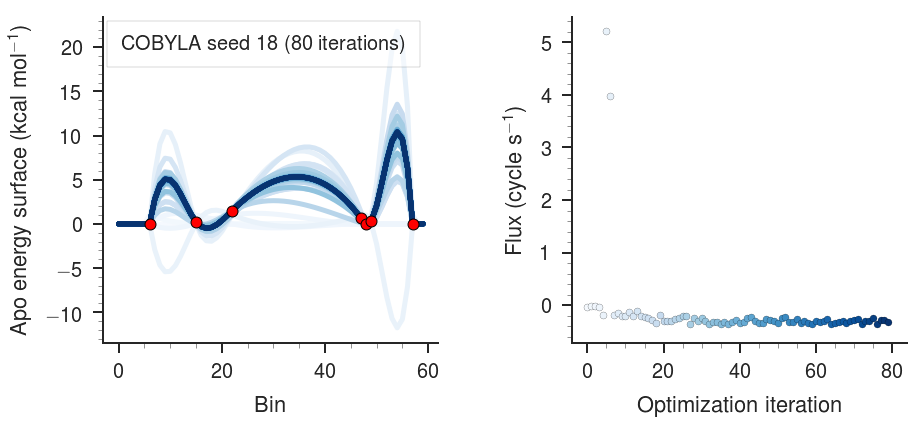

Seed	19	Evaluations	74	Flux	91.63692957632


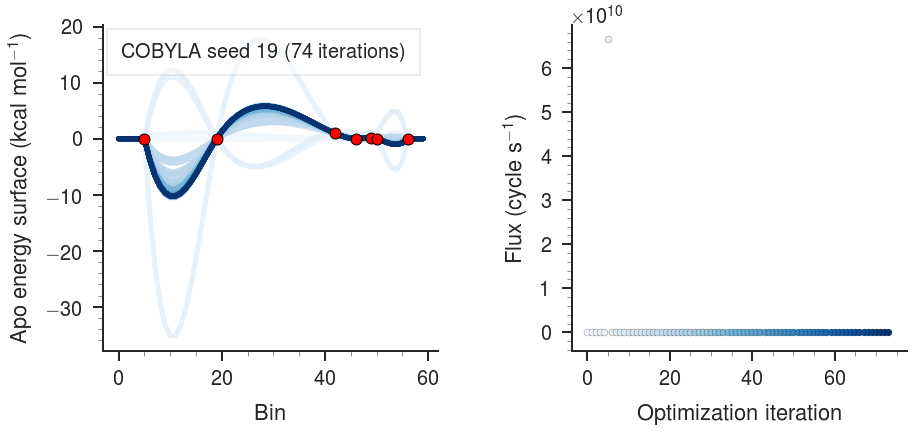

Seed	20	Evaluations	78	Flux	-0.14465873444283564


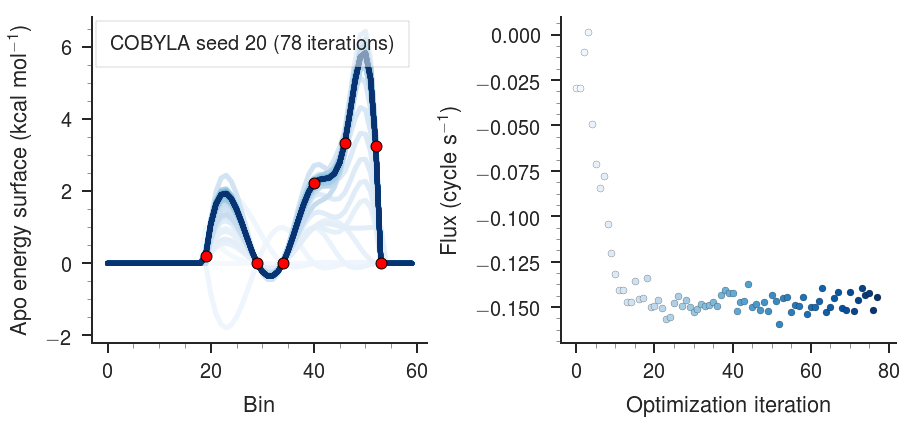

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2628: RuntimeWarning: divide by zero encountered in true_divide
  tmp = dot(tmp,np.diag(1.0/s))
/home/dslochower/data/projects/nonequilibrium-master/motors/simulation.py:232: RuntimeWarning: invalid value encountered in greater
  if np.any(row_sums > 1):


Seed	23	Evaluations	137	Flux	-0.5541136642796346


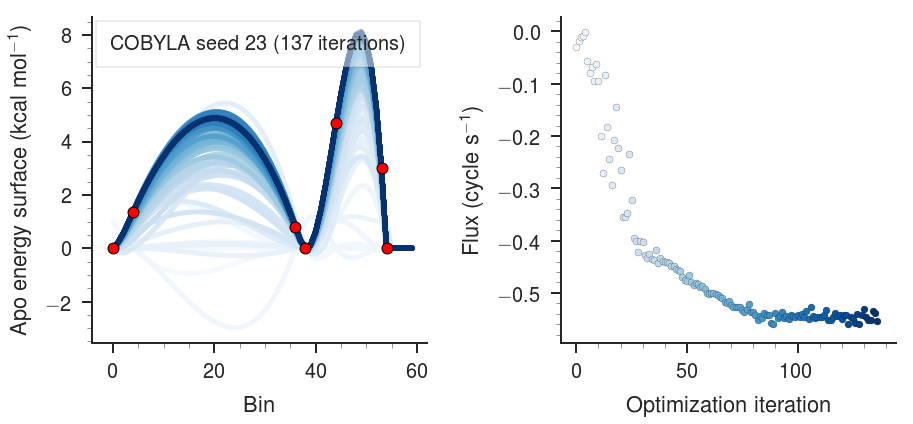

Seed	26	Evaluations	109	Flux	-0.35209916350462434


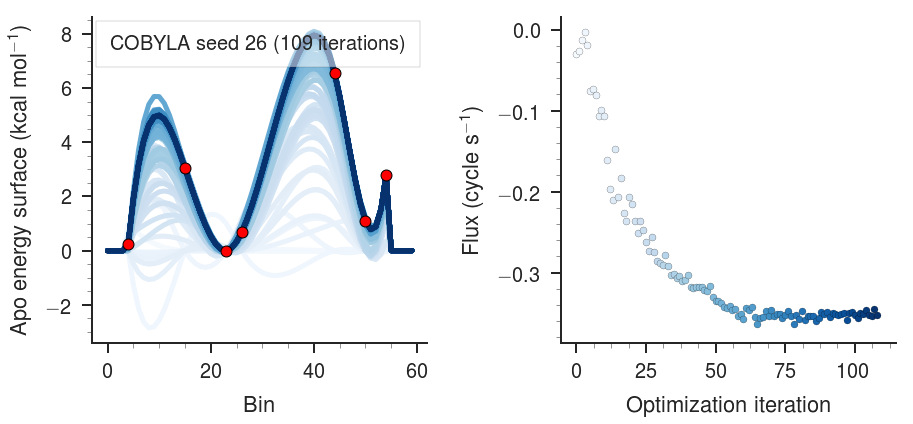

Seed	27	Evaluations	134	Flux	-1.172423014403061


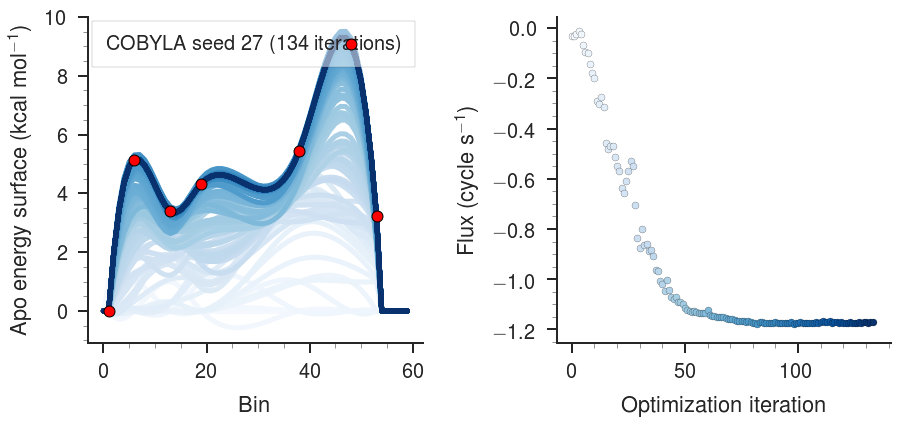

Seed	29	Evaluations	168	Flux	-2.089791585115309


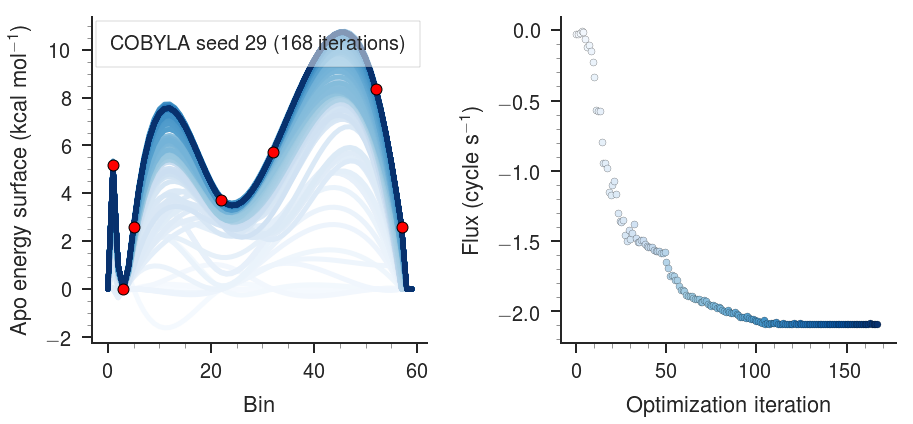

Seed	30	Evaluations	79	Flux	-2481.6819997503626


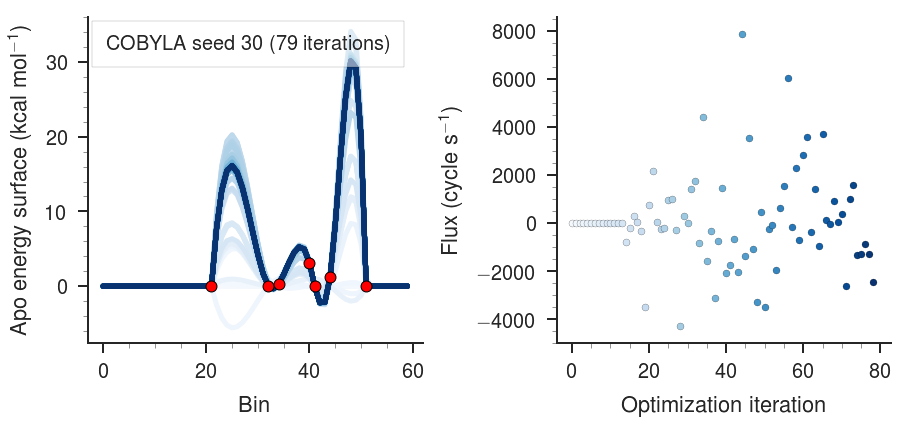

Seed	33	Evaluations	79	Flux	-2.285857065429433e+19


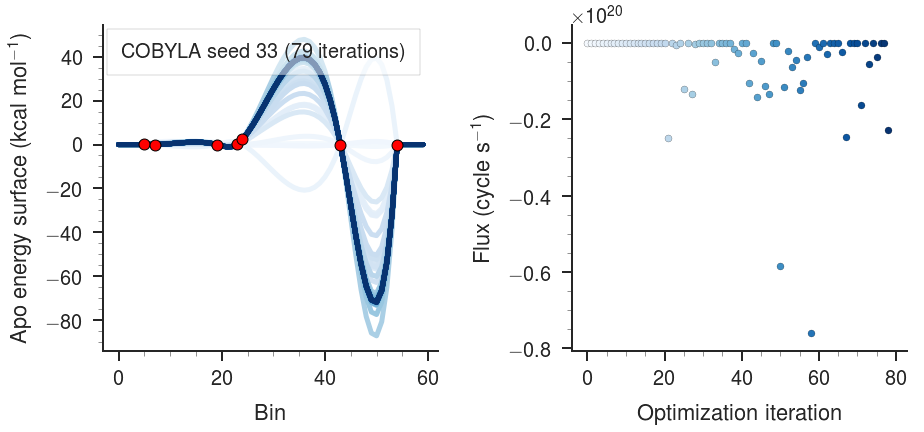

Seed	34	Evaluations	99	Flux	-4.2696012589155806e+29


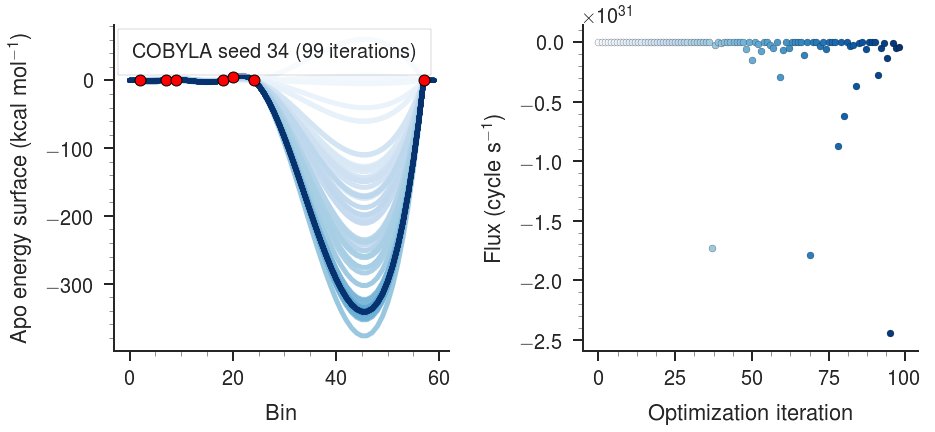

Seed	35	Evaluations	77	Flux	-121060339.47734202


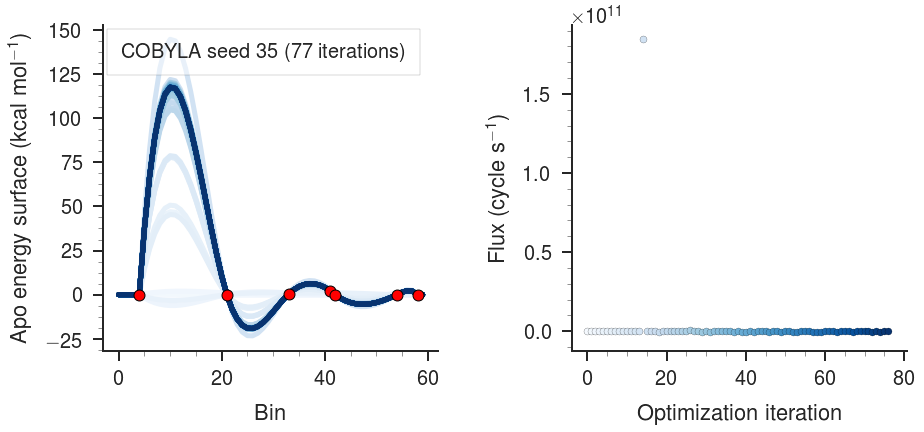

Seed	37	Evaluations	75	Flux	-554650559336.0302


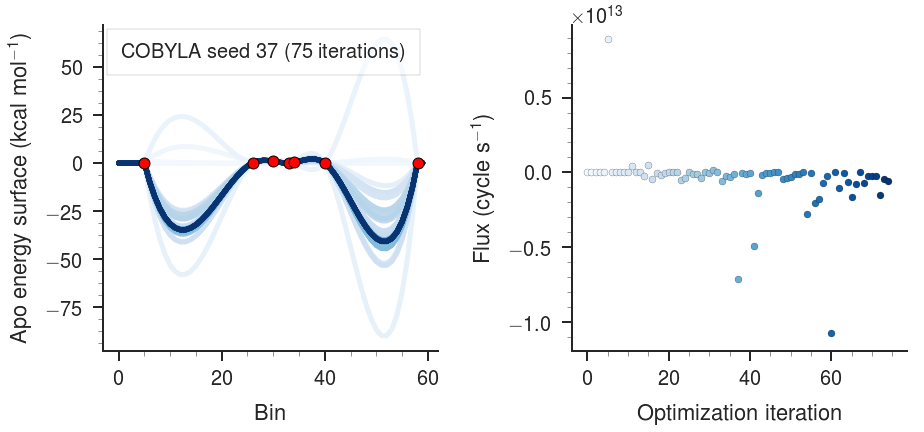

Seed	38	Evaluations	145	Flux	-0.7261309283369447


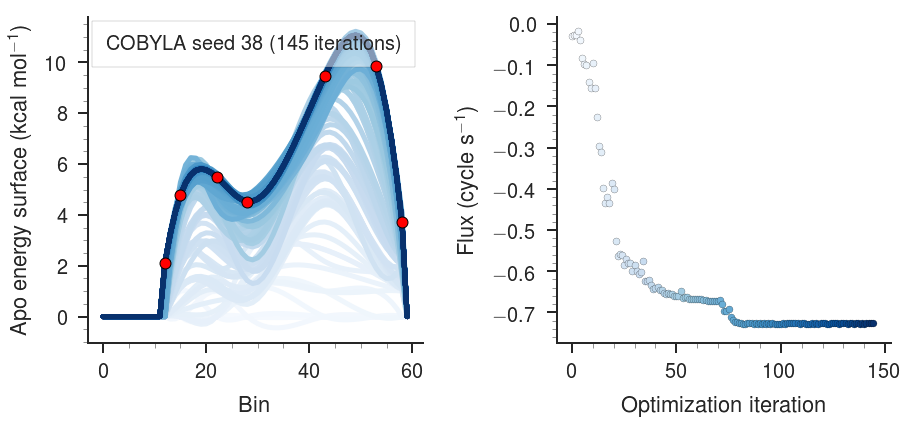

Seed	42	Evaluations	94	Flux	-0.3258972683892959


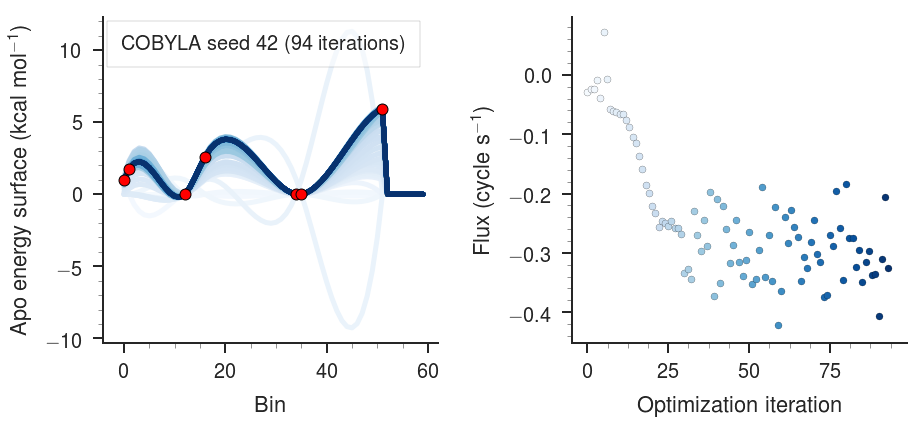

Seed	43	Evaluations	102	Flux	-0.2683183931180982


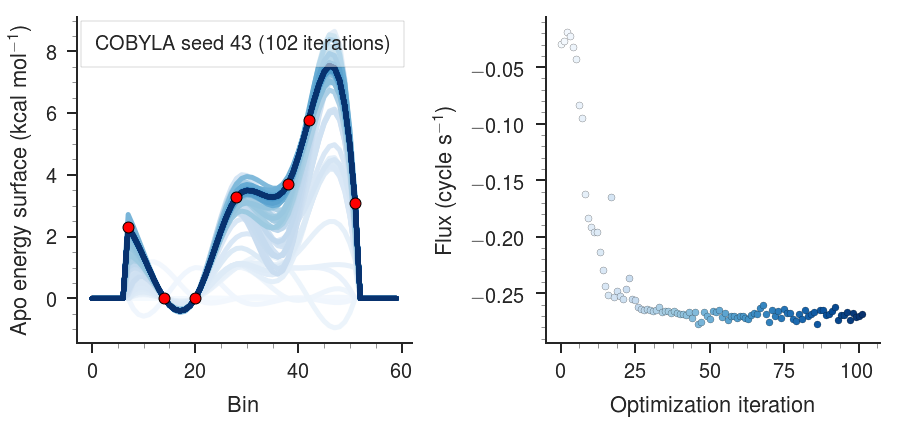

Seed	44	Evaluations	131	Flux	-1.559713304318719


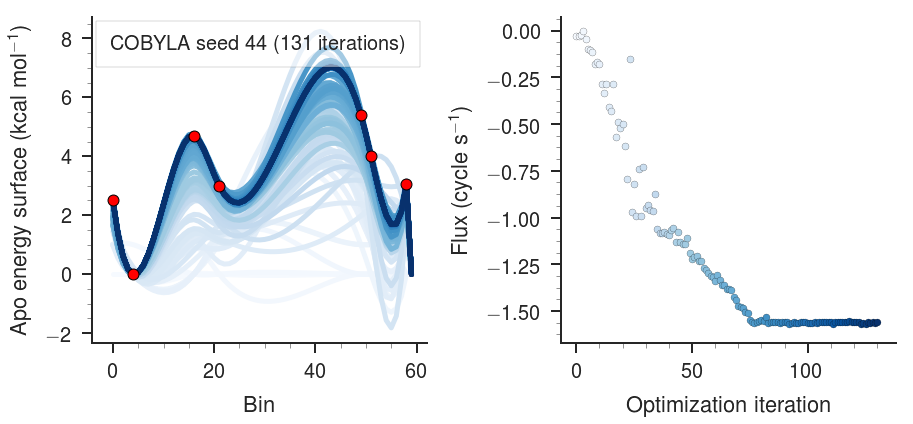

Seed	46	Evaluations	80	Flux	-0.17783455549224095


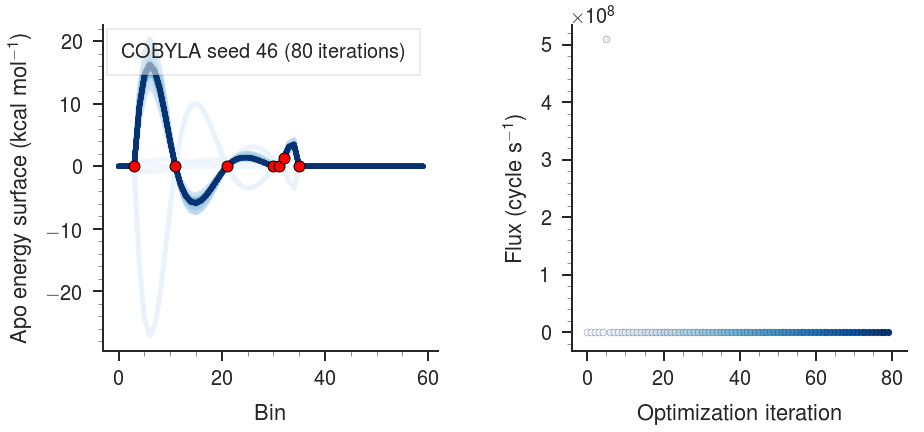

Seed	47	Evaluations	114	Flux	-0.5226310064822447


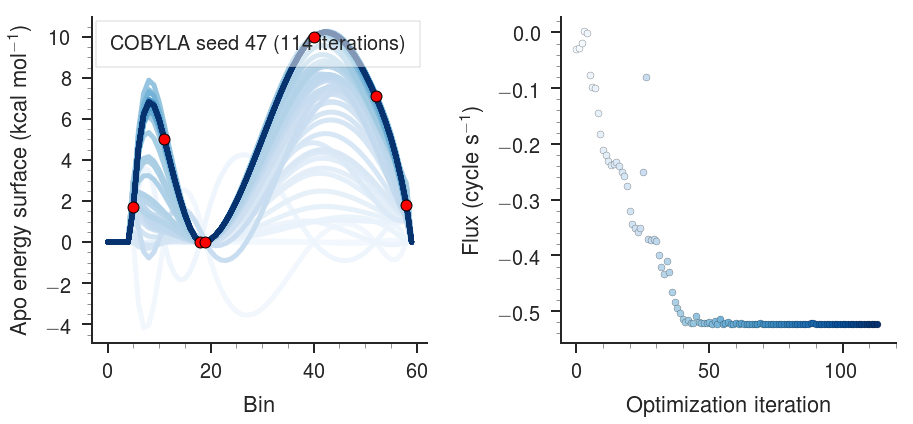

In [52]:
for seed in range(50):
    spline_x = np.sort(np.random.randint(low=0, high=59, size=7))
    guess = [0, 0, 0, 0, 0, 0, 0]
    energies = []
    fluxes = []
    np.random.seed(seed)
    try:
        results = sc.optimize.minimize(objective_pinned, guess, method='COBYLA', args=(spline_x))
        print('Seed\t{}\tEvaluations\t{}\tFlux\t{}'.format(seed, results['nfev'], results['fun']))
        plot_summary(energies, fluxes, 'COBYLA seed {}'.format(seed), results['nfev'], spline_x)
    except:
        continue

In [47]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from motors.simulation import *
from motors.plot import prepare_plot
prepare_plot()
from motors.aesthetics import setup_plot

In [49]:
from motors.plot import paper_plot